In [0]:
"""Importing all the relevant libraries we need."""

import pandas as pd # For data frames
import numpy as np # For math and efficient arrays
import matplotlib.pyplot as plt # For plotting and visualizing data

from sklearn.linear_model import LinearRegression

# So plots appear in this notebook
%matplotlib inline

In [352]:
""" Grab all the data from github, and read it into dataframes"""

# Get the housing price data
housing_data = pd.read_csv('https://raw.githubusercontent.com/Mvalentino92/JAVA/master/train.csv')

# Print the shape of the data, to see how many instances and features there are
print('There are',housing_data.shape[0],'instances,',housing_data.shape[1]-1,
      'features and of course 1 label.')

There are 1460 instances, 80 features and of course 1 label.


In [0]:
# EXERCISE: Is there any feature that should be immediately taken out?
# Maybe there's one thats there, but it really doesn't supply any reasonably correlated info to salesprice.
# Don't think too hard or far when looking! Just take this out right away!

# its the first one! Id
housing_data = housing_data.drop('Id',axis=1)

In [0]:
# Lets seperate the features from the labels
features = housing_data.drop('SalePrice',axis=1)
labels = housing_data['SalePrice']

In [0]:
# Lets split the data between categorical and numerical features so we can operate on each easier, and then recombine
features_cat = pd.DataFrame()
features_num = pd.DataFrame()
for ft in features.columns:
    if np.dtype(features[ft]) is np.dtype('O'):
        features_cat[ft] = features[ft]
    else:
        features_num[ft] = features[ft]

In [0]:
# Lets replace all the NaNs in the categorical dataframe with Missing
for ft in features_cat.columns:
        features_cat[ft].fillna('Missing',inplace=True)

In [0]:
# Now lets onehot encode this, it will return a matrix, so lets call it X_cat to distinguish from dataframes
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
X_cat = onehot.fit_transform(features_cat)

In [0]:
# Alright, now let's split the numerical features
# Since we need to combine the numerical and previously-categorical features back,
# We need to use a specific seed and test_size
test_size = 0.20
random_state=21

from sklearn.model_selection import train_test_split
train_features_num, test_features_num = train_test_split(features_num,test_size=test_size,random_state=random_state)

In [359]:
# Okay, now lets use an imputer to replace the NaNs for the numerical features
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_features_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [0]:
# The imputer will return a matrix, so we'll call is X_num
# Let's fit it to both train and test data
X_train_num = imputer.transform(train_features_num)
X_test_num = imputer.transform(test_features_num)

In [0]:
# Now let's split the previously-categorical feature matrix
X_train_cat, X_test_cat = train_test_split(X_cat,test_size=test_size,random_state=random_state)

In [0]:
# Lets make polynomial features out of the nums
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly.fit(X_train_num)
X_train_num_poly = poly.transform(X_train_num)
X_test_num_poly = poly.transform(X_test_num)

In [0]:
# And let's combine all the training and test data now
X_train = np.hstack((X_train_num_poly,X_train_cat))
X_test = np.hstack((X_test_num_poly,X_test_cat))

In [0]:
# Finally, let's actually split the labels! 
y_train,y_test = train_test_split(np.array(labels),test_size=test_size,random_state=random_state)

In [0]:
# Functions for adding more meaningful data points
def recur(X,avgs,col,minsamples,coldices):

    # Base cases, if X is empty or completed columns, return X
    if X.shape[0] < minsamples or col == avgs.size:
        return X if isinstance(X,list) else [X] 

    # Split into two parts
    less = X[:,coldices[col]] < avgs[coldices[col]]
    L = X[less]
    GE = X[np.logical_not(less)]

    # Recursively call for each
    P1 = recur(L,avgs,col+1,minsamples,coldices)
    P2 = recur(GE,avgs,col+1,minsamples,coldices)

    # Add to list and return
    P1.extend(P2)
    return P1

def addpoints(X,minsamples):

    # Column indices to be mixed up
    coldices = np.arange(0,X.shape[1])

    # Master list of points to return
    retval = np.empty((0,X.shape[1]))
    size = -1

    # List of submatrices to go through
    subspaces = [X]

    # For maxiter
    while retval.shape[0] > size:

        # Update size
        size = retval.shape[0]

        # New subspaces of points list
        nextsubspaces = []

        # Go through every subspace of points
        for ss in subspaces:

            # If subspace is empty, continue
            if len(ss) == 0:
               continue

            # Get the average and add these points to master (only unique, could use Sets but whatever)
            avgs = np.mean(ss,axis=0)
            retval = np.unique(np.vstack((retval,avgs)),axis=0)

            # Get all the new points and add to subspaces
            np.random.shuffle(coldices)
            nextsubspaces.extend(recur(ss,avgs,0,minsamples,coldices))

        # next is now subspaces
        subspaces = nextsubspaces

    # Return retval
    return retval


In [0]:
# Create new matrix with X and y col appeneded to it
M = np.hstack((X_train,y_train.reshape(y_train.shape[0],-1)))

In [0]:
# Generate new points
newM = addpoints(M,65)

In [368]:
# Add these to both X_train and y_train
newX = newM[:,0:-1]
newy = newM[:,-1]

# Stack em up
X_train_extra = np.vstack((X_train,newX))
y_train_extra = np.append(y_train,newy)

# How many points did we add?
print('Added ',len(newy),'more points')

Added  45 more points


In [0]:
# Now since the values are all over the place, let's use a scaler on the data
# Once again, you fit with training data, and transform on training and test data
from sklearn.preprocessing import MinMaxScaler

# Extra
scaler_extra = MinMaxScaler()
scaler.fit(X_train_extra)
X_train_extra = scaler.transform(X_train_extra)
X_test_extra = scaler.transform(X_test)

# Original
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
# And compare to the actual values using some accuracy metric
# Im going to wrap this in a function
import sklearn.metrics as mt

def print_accuracies(y_test,y_predict,plot_it=True):
    # Mean squared error
    print('The MSE is: ',mt.mean_squared_error(y_test,y_predict))

    # Mean log squared error, but lets check for negatives first!
    hasneg = any([ele < 0 for ele in y_predict])
    if not(hasneg):
        print('The MSLE is: ',mt.mean_squared_log_error(y_test,y_predict))

    # Mean absolute error 
    print('The MAE is: ',mt.mean_absolute_error(y_test,y_predict))

    # mean absolute percfent error
    MAPE = np.sum(np.abs((y_test - y_predict)/y_test))*100/len(y_test)
    print('The MAPE is: ',MAPE)

    # Plot it
    if plot_it:
        plt.scatter(y_test,y_predict)
        plt.scatter(y_test,y_test)

The MSE is:  1169427844.2787127
The MSLE is:  0.018773587580897276
The MAE is:  17068.179169079594
The MAPE is:  9.504517943351502


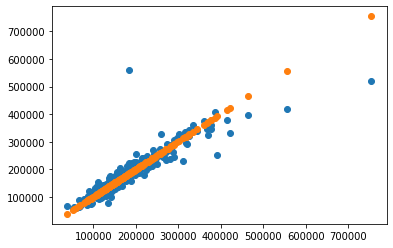

In [371]:
from sklearn.linear_model import Ridge

# Extra
reg = Ridge(alpha=35)
reg.fit(X_train_extra,y_train_extra)
y_predict = reg.predict(X_test_extra)
print_accuracies(y_test,y_predict)

The MSE is:  1170451436.0067265
The MSLE is:  0.01880979148753034
The MAE is:  17077.588043222153
The MAPE is:  9.515607889344473


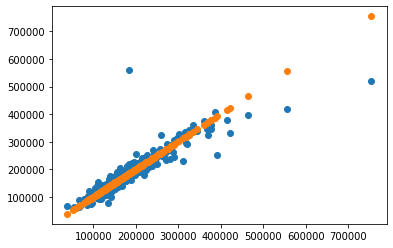

In [372]:
# Original
reg = Ridge(alpha=35)
reg.fit(X_train,y_train)
y_predict = reg.predict(X_test)
print_accuracies(y_test,y_predict)